# Pre-processing

This notebook is used to pre-process the dataset (Descriptions of the books) to prepare it for the recommendation system. It includes several methods, a lot of them was taken from [arabic-text-preprocessing](https://github.com/saobou/arabic-text-preprocessing/blob/master/Preprocess.ipynb). In addition, a couple of different modules were used, so you have to install them before running this notebook.

Note: later on, I will try to re-write this notebook via [pyarabic](https://github.com/linuxscout/pyarabic/blob/master/doc/features.md), [farasapy](https://github.com/MagedSaeed/farasapy), [tnkeeh](https://github.com/ARBML/tnkeeh), and [tkseem] (https://github.com/ARBML/tkseem).

## 1. Seeting up

### 1.1 Importing The Modules

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
#pd.set_option('display.max_colwidth', -1) # To display whole data in columns

In [2]:
import nltk
import ssl

In [3]:
# https://stackoverflow.com/questions/41610543/corpora-stopwords-not-found-when-import-nltk-library
# You have to do it once in the begining 
'''try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()'''

'try:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\nnltk.download()'

In [4]:
from nltk.corpus import stopwords

import pyarabic.araby as araby
import pyarabic.number as number

from textblob import TextBlob
import re

#from tashaphyne.stemming import ArabicLightStemmer # I did it but it led to bad stemming
#from nltk.stem.isri import ISRIStemmer

In [5]:
from farasa.pos import FarasaPOSTagger # EDA
from farasa.ner import FarasaNamedEntityRecognizer # EDA
from farasa.segmenter import FarasaSegmenter # Done on description, I should do it on 
from farasa.stemmer import FarasaStemmer 

### 1.2 Preparing The Dataset

In [6]:
books = pd.read_csv('Data/Books_Data/Descriptions_Dataset.csv')

In [7]:
books = books.drop(['Unnamed: 0'], axis = 1) #, 'ISBN', 'Title', 'Author', 'Genres', 'URL', 'Cover_URL'

In [8]:
books.head()

,Title,Author,Description,Genres,URL,Cover_URL
0,استمتع بحياتك,محمد عبد الرحمن العريفي,لما كنت فى السادسة عشرة من عمري وقع فى يدي كتا...,علوم إسلامية رقائق,https://www.abjjad.com/book/15445916/%D8%A7%D8...,https://abjjadst.blob.core.windows.net/pub/2f2...
1,عبقرية عمر,عباس محمود العقاد,يزخر التاريخ الإسلامي برجال عِظام سطروا حوادثه...,علوم إسلامية سيرة الصحابة,https://www.abjjad.com/book/15445340/%D8%B9%D8...,https://abjjadst.blob.core.windows.net/pub/e5f...
2,عبقرية محمد,عباس محمود العقاد,احتفى التاريخ العربي بالسيرة المُحمدية؛ فأفرد ...,علوم إسلامية السيرة النبوية,https://www.abjjad.com/book/15445339/%D8%B9%D8...,https://abjjadst.blob.core.windows.net/pub/7df...
3,لأنك الله : رحلة إلى السماء السابعة,علي بن جابر الفيفي,كتاب يتحدث عن بعض أسماء الله الحسنى وكيف نعيشه...,علوم إسلامية رقائق,https://www.abjjad.com/book/2653683959/%D9%84%...,https://abjjadst.blob.core.windows.net/pub/c35...
4,عبقرية الإمام علي,عباس محمود العقاد,بَرَع «عباس محمود العقاد» في تناول شخصية الإما...,علوم إسلامية سيرة الصحابة,https://www.abjjad.com/book/15445343/%D8%B9%D8...,https://abjjadst.blob.core.windows.net/pub/0b2...


### 1.3 Examining The Data Before Pre-processing

In [9]:
# Function to remove stop words
def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in all_stopwords and len(w) >= 2])
    #return " ".join([w for w in words if not w in stop_words and not w in stop_word_comp and len(w) >= 2])

# https://github.com/mohataher/arabic-stop-words
all_stopwords = list(set(stopwords.words("arabic"))) + pd.read_csv('Data/Pre-processing/Stopwords.txt').iloc[:, 0].values.tolist()

#OR
#stop_words1 = list(set(stopwords.words("arabic")))
#stop_words2 = pd.read_csv('arabic-stop-words/list.txt')
#stop_words2 = stop_words2.iloc[:, 0].values.tolist()

In [10]:
# Getting stats about Description of the books
import emoji
def avg_word(sentence):
    words = sentence.split()
    if len(words) == 0:
        return 0
    return (sum(len(word) for word in words)/len(words))

def emoji_counter(sentence):
    return emoji.emoji_count(sentence)

books['word_count'] = books['Description'].apply(lambda x: len(str(x).split(" ")))
books['char_count'] = books['Description'].str.len() ## this also includes spaces
books['avg_char_per_word'] = books['Description'].apply(lambda x: avg_word(x)) 
books['stopwords'] = books['Description'].apply(lambda x: len([x for x in x.split() if x in all_stopwords])) # I did it instead of the next 2 lines, so I make sure to have the same list of stopped words in the whole notebook. OR: 
#stop = stopwords.words('arabic')
#books['stopwords'] = books['Description'].apply(lambda x: len([x for x in x.split() if x in stop]))
books['emoji_count'] = books['Description'].apply(lambda x: emoji_counter(x))

In [11]:
books.sort_values(by='emoji_count',ascending=[0])
#books.head()

,Title,Author,Description,Genres,URL,Cover_URL,word_count,char_count,avg_char_per_word,stopwords,emoji_count
97,سر الآيات والعدد في شفاء الروح والجسد,رضوان سعيد فقيه,أخطأ كلّ من ظنّ أن القرآن شفاء للروح والقلب فق...,علوم إسلامية علوم القرآن علوم إسلامية الطب النبوي,https://www.abjjad.com/book/2195818503/%D8%B3%...,https://abjjadst.blob.core.windows.net/pub/322...,215,1341,5.247664,55,16
1807,العلوم الغريبة في الميزان,رضوان سعيد فقيه,يحتوي هذا الكتاب على: - السحر - النجوم - الحرو...,غرائب وأساطير غرائب العلوم والطبيعة عام,https://www.abjjad.com/book/2210365934/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/e70...,172,1087,5.296512,26,16
1800,العلوم الغريبة في الميزان,رضوان سعيد فقيه,هذا كتاب يتحدث فيه المؤلف عن جملة من العلوم ال...,غرائب وأساطير غرائب,https://www.abjjad.com/book/2195818455/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/092...,160,1061,5.606250,31,16
135,الكنوز العلية في العلاجات الروحانية,رضوان سعيد فقيه,يتضمن هذا الكتاب بعض من الاحاديث التي تتحدث عن...,غرائب وأساطير أسرار علوم إسلامية الطب النبوي,https://www.abjjad.com/book/2195883917/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/98d...,181,1171,5.447514,39,16
5354,الحقائق العلمية في الاستشفاء بالطاقة القرآنية,رضوان سعيد فقيه,هذا الكتاب الذي بين يديك يتضمن دراسات عديدة حو...,NaN,https://www.abjjad.com/book/2195785466/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/e99...,182,1198,5.560440,43,16
...,...,...,...,...,...,...,...,...,...,...,...
4744,سفرة أناهيد الصينية (سلسلة سفرة اناهيد),أﻧﺎھﯿﺪ دوﻧﯿﻜﯿﺎن,من الشرق إلى الغرب ومن الشمال إلى الجنوب تنقلك...,طبخ وطعام مطبخ عالمي,https://www.abjjad.com/book/2179597020/%D8%B3%...,https://abjjadst.blob.core.windows.net/pub/dec...,34,198,5.000000,8,0
4745,أشهى الأطباق الشامية,دار الحضارة للنشر والتوزيع,الكتاب طبعة ثانية.\n\nهذا الكتاب يطرح الكثير م...,طبخ وطعام مطبخ عربي,https://www.abjjad.com/book/2181923362/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/170...,48,295,5.444444,7,0
4746,أروع الفطائر والمعجنات,زينة عبد القادر مريشد,الكتاب طبعة أولى.\n\nمجموعة متنوعة من الأطعمة ...,طبخ وطعام مخبوزات,https://www.abjjad.com/book/2181923483/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/54e...,17,112,5.529412,1,0
4747,حلا لا يقاوم,حنان محمد السيد إبراهيم,الكتاب طبعة ثانية.\n\nيحتوي هذا الكتاب على وصف...,طبخ وطعام حلويات,https://www.abjjad.com/book/2181956229/%D8%AD%...,https://abjjadst.blob.core.windows.net/pub/3f2...,36,211,4.833333,7,0


## 2. Text Cleaning

### 2.1 Text Segmentation

In [12]:
# instantiate Farasa segmenter and preprocess text
segmenter = FarasaSegmenter(interactive=True)

for index, i in enumerate(books['Description']):
        text = segmenter.segment(i)     # segment all texts in Description
        books['Description'][index] = text

[2020-12-16 20:12:56,091 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [13]:
for index, i in enumerate(books['Description']):
        books['Description'][index] = re.sub(" +", " ", i) # removes all sepcial chars

### 2.2 Remove emojis in a string


In [14]:
with open('Data/Pre-processing/emojis.csv','r',encoding='utf-8') as f:
    lines = f.readlines()
    emojis_ar = {}
    for line in lines:
        line = line.strip('\n').split(';')
        emojis_ar.update({line[0].strip():line[1].strip()})

In [15]:
from __future__ import unicode_literals

def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

import unicodedata
from unidecode import unidecode

def emoji_native_translation(text):
    text = text.lower()
    loves = ["<3", "♥",'❤']
    smilefaces = []
    sadfaces = []
    neutralfaces = []

    eyes = ["8",":","=",";"]
    nose = ["'","`","-",r"\\"]
    for e in eyes:
        for n in nose:
            for s in ["\)", "d", "]", "}","p"]:
                smilefaces.append(e+n+s)
                smilefaces.append(e+s)
            for s in ["\(", "\[", "{"]:
                sadfaces.append(e+n+s)
                sadfaces.append(e+s)
            for s in ["\|", "\/", r"\\"]:
                neutralfaces.append(e+n+s)
                neutralfaces.append(e+s)
            #reversed
            for s in ["\(", "\[", "{"]:
                smilefaces.append(s+n+e)
                smilefaces.append(s+e)
            for s in ["\)", "\]", "}"]:
                sadfaces.append(s+n+e)
                sadfaces.append(s+e)
            for s in ["\|", "\/", r"\\"]:
                neutralfaces.append(s+n+e)
                neutralfaces.append(s+e)

    smilefaces = list(set(smilefaces))
    sadfaces = list(set(sadfaces))
    neutralfaces = list(set(neutralfaces))
    t = []
    for w in text.split():
        if w in loves:
            t.append("حب")
        elif w in smilefaces:
            t.append("مضحك")
        elif w in neutralfaces:
            t.append("عادي")
        elif w in sadfaces:
            t.append("محزن")
        else:
            t.append(w)
    newText = " ".join(t)
    return newText

import emoji
def is_emoji(word):
    if word in emojis_ar:
        return True
    else:
        return False
    
def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

from aiogoogletrans import Translator
translator = Translator()
import asyncio
loop = asyncio.get_event_loop()
def translate_emojis(words):
    word_list = list()
    words_to_translate = list()
    for word in words :
        t = emojis_ar.get(word.get('emoji'),None)
        if t is None:
            word.update({'translation':'عادي','translated':True})
            #words_to_translate.append('normal')
        else:
            word.update({'translated':False,'translation':t})
            words_to_translate.append(t.replace(':','').replace('_',' '))
        word_list.append(word)
    return word_list

def emoji_unicode_translation(text):
    text = add_space(text)
    words = text.split()
    text_list = list()
    emojis_list = list()
    c = 0
    for word in words:
        if is_emoji(word):
            emojis_list.append({'emoji':word,'emplacement':c})
        else:
            text_list.append(word)
        c+=1
    emojis_translated = translate_emojis(emojis_list)
    for em in emojis_translated:
        text_list.insert(em.get('emplacement'),em.get('translation'))
    text = " ".join(text_list)
    return text
    
def clean_emoji(text):
    text = emoji_native_translation(text)
    text = emoji_unicode_translation(text)
    return text

### 2.3 Text Standarization and Cleaning

In [16]:
# I used Farasa for segmentation and stemming

'''ArListem = ArabicLightStemmer()

def to_arabic(text):
    return ds.transliterate(text)

def stem(text):
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ArListem.light_stem(w)
        cleaned.append(ArListem.get_root())
    return " ".join(cleaned)
'''

def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

In [17]:
def clean_description(text):
    text = re.sub('#\d+K\d+', ' ', text)  # years like 2K19
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('\\n|\\t', ' ', text)  # remove \n and \t
    text = re.sub('@[^\s]+',' ',text)
    #text = clean_hashtag(text)
    text = clean_emoji(text)
    return text

In [18]:
def clean_text(text):
    ## Clean for description
    text = clean_description(text)
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    ## Remove Emojis
    text = remove_emoji(text)
    ## Convert text to lowercases
    text = text.lower()
    ## Arabisy the text
    #text = to_arabic(text)
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text) 
    text = re.sub(r'\s*[A-Za-z]+\b', '' , text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    #Stemming
    #text = stem(text)

    return text

books['Description'] = books['Description'].apply(lambda x:clean_text(x))

### 2.4 Stemming

In [19]:
# instantiate Farasa stemmer and preprocess text
stemmer = FarasaStemmer(interactive=True)

for index, i in enumerate(books['Description']):
        text = stemmer.stem(i)     # stemming
        books['Description'][index] = text

[2020-12-16 20:20:29,552 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


### 2.5 Removing high frequent and rare words

In [20]:
### Common word removal
freq = pd.Series(' '.join(books['Description']).split()).value_counts()[:12]
freq = list(freq.index)
books['Description'] = books['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
### Rare words removal
freq = pd.Series(' '.join(books['Description']).split()).value_counts()[-50:]
freq = list(freq.index)
books['Description'] = books['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
### Remove Numbers from text

### 2.6 Examining The Data After Pre-processing

In [21]:
### Discover Data again after cleaning
books['word_count'] = books['Description'].apply(lambda x: len(str(x).split(" ")))
books['char_count'] = books['Description'].str.len() ## this also includes spaces
books['avg_char_per_word'] = books['Description'].apply(lambda x: avg_word(x))
stop = stopwords.words('arabic')
books['stopwords'] = books['Description'].apply(lambda x: len([x for x in x.split() if x in stop]))
books['emoji_count'] = books['Description'].apply(lambda x: emoji_counter(x))

In [22]:
books.sort_values(by='Description',ascending=[1])

,Title,Author,Description,Genres,URL,Cover_URL,word_count,char_count,avg_char_per_word,stopwords,emoji_count
6598,الفن والإنسان,Mouad assila fkhatre wlad dar lgdari wahde wah...,,NaN,https://www.abjjad.com/book/2174977603/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/b16...,1,0,0.000000,0,0
9327,Essentials of Environmental Science,Kamala dorsner,,تاريخ وجغرافيا دراسات جغرافية زراعة وحيوان علم...,https://www.abjjad.com/book/2749005827/essenti...,https://abjjadst.blob.core.windows.net/pub/0e7...,1,0,0.000000,0,0
13753,تيست ٣,أبجد تيست,,قانون قانون بحري وجوي,https://www.abjjad.com/book/2706636800/%D8%AA%...,https://abjjadst.blob.core.windows.net/pub/c08...,1,0,0.000000,0,0
4777,اللحوم (سلسلة مطبخ العروس للطبخ العالمي),إفتخار عدنان الهندي,,طبخ وطعام مطبخ عالمي,https://www.abjjad.com/book/2181300447/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/07e...,1,0,0.000000,0,0
9425,THE DATE PALM,Warda H. Bircher,,زراعة وحيوان علم النبات,https://www.abjjad.com/book/2196308008/the-dat...,https://abjjadst.blob.core.windows.net/pub/630...,1,0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
986,يوميات اتنين متجوزين,مروة حلمي,يوم لذيذ جد,NaN,https://www.abjjad.com/book/2170159300/%D9%8A%...,https://abjjadst.blob.core.windows.net/pub/386...,3,11,3.000000,0,0
6344,ديوان يوميات مجنون ليلى,محمد امين بني تميم,يوم مجنون ليلي ديوان شعر فصحي شاعر محمد أمين ب...,فنون فن الكتابة أدب دواوين شعر أدب نثر,https://www.abjjad.com/book/2198864279/%D8%AF%...,https://abjjadst.blob.core.windows.net/pub/05e...,99,520,4.262626,0,0
11128,لا شيء لا أحد.. يوميات في الشمال الأوروبي,فاروق يوسف,يوم مزج كاتب تأمل خاطر سطر شعر سر تطغي جزء تحو...,سفر ورحلات أدب رحلات,https://www.abjjad.com/book/2173698441/%D9%84%...,https://abjjadst.blob.core.windows.net/pub/c39...,43,202,3.720930,0,0
11002,يوميات ميونخ 2001-2004,حسونة المصباحي,يوم ميونخ فتح حسون مصباح بابا ولج قارء كاتب اط...,سفر ورحلات أدب رحلات,https://www.abjjad.com/book/2175535317/%D9%8A%...,https://abjjadst.blob.core.windows.net/pub/5cb...,157,765,3.878981,1,0


### 2.7 Remove Non-Arabic books or description
After the preprocessing, some books descriptions became empty or consist of non Arabic text. So, we removed them manually. 

In [23]:
books = books[books['Description'].notna()]  # also used fillna but the empty descriptions look like not empty

In [24]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 14199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              14200 non-null  object 
 1   Author             14193 non-null  object 
 2   Description        14200 non-null  object 
 3   Genres             13393 non-null  object 
 4   URL                14200 non-null  object 
 5   Cover_URL          14196 non-null  object 
 6   word_count         14200 non-null  int64  
 7   char_count         14200 non-null  int64  
 8   avg_char_per_word  14200 non-null  float64
 9   stopwords          14200 non-null  int64  
 10  emoji_count        14200 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.3+ MB


In [25]:
# I can delete the books with word_count less than 5 words, they are almost have no description or it is just words like: عظيم! (Great!)
books = books[books["word_count"] >= 5]

In [26]:
books.shape

(14072, 11)

In [27]:
books.sort_values(by='word_count',ascending=[1]).head() 

,Title,Author,Description,Genres,URL,Cover_URL,word_count,char_count,avg_char_per_word,stopwords,emoji_count
13169,الإستــاتيــكا,أمجد إبراهيم شحادة,تحدث استاتيكا اتزان اجسام احتكاك,العلوم والطبيعة رياضيات,https://www.abjjad.com/book/2188935256/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/022...,5,32,5.6,0,0
10266,الثقة في النفس؛ كيف تتغلب على مخاوفك وتحقق أهد...,مايك ماكليمنت,ثق تغلب مخافة تحقق أهداف,علوم إجتماعية علم إجتماع علم النفس تنمية بشرية...,https://www.abjjad.com/book/2200143482/%D8%A7%...,https://abjjadst.blob.core.windows.net/pub/590...,5,24,4.0,0,0
5966,قبيلة البوشعبان العربية الزبيدية ؛ تاريخ ونسب,هشام المسراوي الشعباني الزبيدي,ملحق صورة مشجر قباءل زبيدي,NaN,https://www.abjjad.com/book/2209055153/%D9%82%...,https://abjjadst.blob.core.windows.net/pub/86e...,5,26,4.4,0,0
12644,جبيل القديس,يوسف محمود جربوع,جند قدس قيام مارون موت,NaN,https://www.abjjad.com/book/2724823045/%D8%AC%...,https://www.abjjad.com/images/ubook.jpg,5,22,3.6,0,0
13457,مهارات القيادة في المجال الرياضي,مصطفى حسين باهي,تحميل مهار قياد مجال رياضي,رياضة وتسالي عام,https://www.abjjad.com/book/2451572230/%D9%85%...,https://abjjadst.blob.core.windows.net/pub/493...,5,26,4.4,0,0


In [28]:
# Remove Non-Arabic books or description
# books = books.drop([7762, 7306, 6598, 4915, 4916, 1843, 8010, 9425, 4942, 8185, 8207, 9327, 11870, 4777, 10583, 2128, 13753, 4244, 11184, 4943, 4048, 3847, 4464, 1842], axis=0)

In [29]:
'''final = []
for index, row in books.iterrows():
    if len(row['Description'].split()) > 3:
        final.append([row['Title'], row['Description'], row['Author'], row['Genres'], row['URL'], row['Cover_URL']])
df = pd.DataFrame(final)
df.columns = ['Title','Description', 'Author', 'Genres', 'URL', 'Cover_URL']
df.to_csv('Final_Cleaned.csv',index=False)'''

"final = []\nfor index, row in books.iterrows():\n    if len(row['Description'].split()) > 3:\n        final.append([row['Title'], row['Description'], row['Author'], row['Genres'], row['URL'], row['Cover_URL']])\ndf = pd.DataFrame(final)\ndf.columns = ['Title','Description', 'Author', 'Genres', 'URL', 'Cover_URL']\ndf.to_csv('Final_Cleaned.csv',index=False)"

## 3. Exploring The Texts
Explore the descriptions texts

### 3.1 Basic Statistics

In [30]:
from bayanat.bayanat import bayant

In [31]:
books['Description'].to_csv('Data/Books_Data/Preprocessed_Descriptions.csv',index=False)

In [32]:
Descriptions = bayant('Data/Books_Data/Preprocessed_Descriptions.csv')

In [33]:
Descriptions.get_top_largest_words(25) # as we see, some words have issue

[('بيروتذاتشرفوردهامريكانليالتلصصالعمامه', 37),
 ('واقمارهاعطاردالزهرهالمريخالمشتريزحل', 35),
 ('الاداريهالفلسفهالفنونالقانوناللغه', 33),
 ('النفسالجغرافياالحاسوبالسياحه', 28),
 ('الصوتيهالتليفزيونالسنمامجلات', 28),
 ('يلحقبركبالحياهالعلميهالحديثه', 28),
 ('واعتذارمقدمهالماركسيهالقضيه', 27),
 ('ونماذجواهميتهمعاييرهاالفصل', 26),
 ('الفهرسالاهداءالمقدمهالفصل', 25),
 ('الكهروحيويالاورموسالنظريه', 25),
 ('المءلفالدكتورخزعلالماجدي', 24),
 ('الجامعهابراكسسشيزوفرينيا', 24),
 ('الاولالمراصدالمطيافالفصل', 24),
 ('التعليميهالقيادهالسيطره', 23),
 ('الولادهالرضاعهالتغيرات', 22),
 ('الرءيسيهالتاريخالتربيه', 22),
 ('العراقيهماجستيرالاداره', 22),
 ('الاليكترونيهتمرينالفصل', 22),
 ('اورانوسنبتونبلوتوالفصل', 22),
 ('الفريزالتمرالجزرشوربه', 21),
 ('والاعلامالعلميهالعلوم', 21),
 ('البكالوريوسوالماجستير', 21),
 ('اليوميهالطعامالعلاقات', 21),
 ('ويصدقونالاغنيهوهشاشه', 20),
 ('كاللسانياتالتوليديه', 19)]

In [34]:
Descriptions.get_ratio_of_non_arabic()

0.19621258889100845

In [35]:
Descriptions.get_ratio_of_english()

1.304147770849855e-06

In [36]:
Descriptions.get_ratio_of_arabic()

0.8037872925501033

### 3.2 Visualization

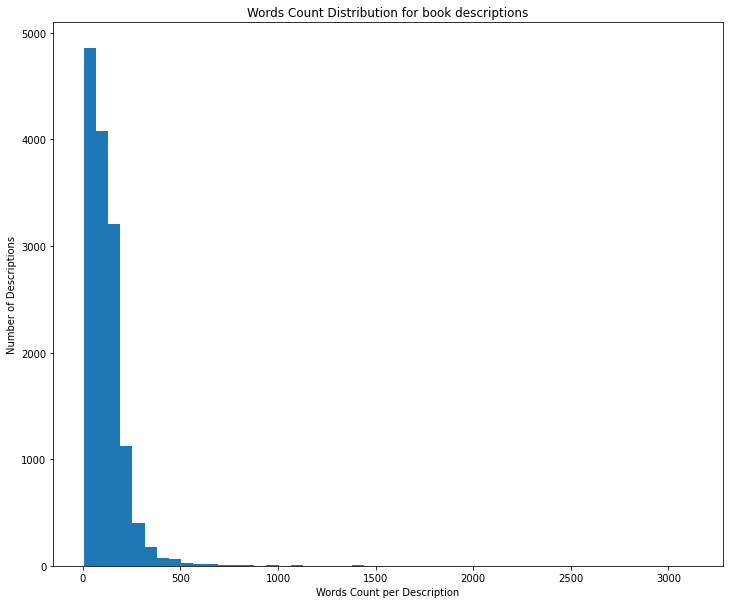

In [27]:
# Plotting the words count for book description
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.title("Words Count Distribution for book descriptions")
plt.hist(books['word_count'], density=False, bins=50)  # `density=False` would make counts
plt.ylabel('Number of Descriptions')
plt.xlabel('Words Count per Description')
plt.savefig('Plots/Wordscount_Distribution.png', dpi=100)

In [28]:
# As we see, we have only 112 books with more than 500 words for their descriptions. 
# So, we will remove them and only consider the books with descriptions less than 500 words 
books[books["word_count"] > 500].shape

(111, 11)

In [33]:
books = books[books["word_count"] < 500]

In [35]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13960 entries, 0 to 14199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              13960 non-null  object 
 1   Author             13954 non-null  object 
 2   Description        13960 non-null  object 
 3   Genres             13193 non-null  object 
 4   URL                13960 non-null  object 
 5   Cover_URL          13956 non-null  object 
 6   word_count         13960 non-null  int64  
 7   char_count         13960 non-null  int64  
 8   avg_char_per_word  13960 non-null  float64
 9   stopwords          13960 non-null  int64  
 10  emoji_count        13960 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.3+ MB


In [36]:
# Save the pre-processed dataset
books.to_csv('Data/Books_Data/Preprocessed_Dataset.csv',index=False)

In [42]:
#https://amueller.github.io/word_cloud/auto_examples/arabic.html
#https://stackoverflow.com/questions/49384111/reflect-arabic-word-cloud

<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for comments'}>

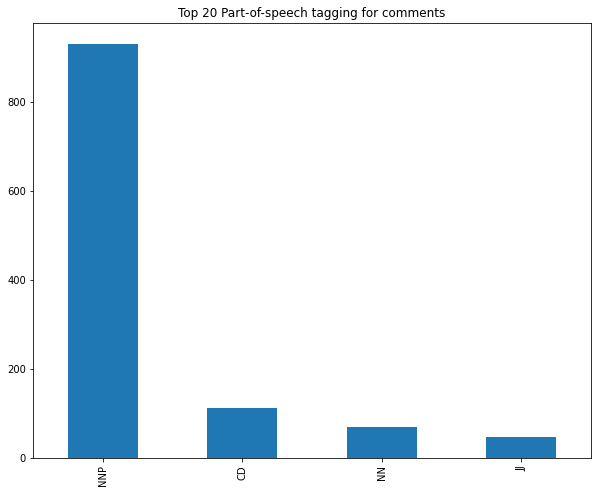

In [43]:
from textblob import TextBlob
blob = TextBlob(str(books['Description']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(kind = 'bar', figsize=(10, 8), title = "Top 20 Part-of-speech tagging for comments")